# IL027 Computer Modelling for All

### Lecture 2 Differential Equations and Plotting

#### James Kermode, School of Engineering and Christoph Ortner, Mathematics

### Overview

- Review of first order differntial equations
- Simple example base on radioactive decay and carbon dating
- Plotting of results using `Plots.jl`
- Integrating using a simple forward Euler scheme
- Using `OrdinaryDiffEq.jl` (part of the larger `DifferentialEquations.jl` suite)
- More complex example: SIR model from epidemiology
- Introduce assignment: population growth

## Radioactive decay

- Differential equations describe how the **rates** of quantities change
- A simple example is radioactive decay, where the rate of decay of a radioactive substance is proportional to the number of particles there are currently
- In a small amount of time $\Delta t$, the change in the number of particles $\Delta N$ is proportional to $N \Delta t$, i.e. 
$$
\Delta N \propto - N \Delta t
$$
- The negative sign indicates the number of particles $N$ decreases as time $t$ increases
- Dividing by $\Delta t$ and taking the limit as $\Delta t \to 0$
$$
\frac{dN}{dt} \propto - N
$$
- Introducing a constant of propotionality $\lambda$ leads to a first order ordinary differential equation (ODE)
$$
\frac{dN}{dt} = - \lambda N
$$

## Analytic solution

- This ODE can be solved directly by separating variables and integrating both sides

\begin{eqnarray}
\int \frac{dN}{N} & = & - \int \lambda\, dt \\
\log N & = & - \lambda t + c \\
N & = & e^c e^{-\lambda t} \\
\end{eqnarray}

- Specifying the initial conditon $N(0) = N_0$ allows the constant of integration $c$ to be determined. 
- The specific solution is $N(t) = N_0 e^{-\lambda t}$, i.e. expontential decay in the number of particles as time passes.
- This leads to the idea of the *half-life*, the time taken for half of a given sample to decay, $t_{1/2} = \log 2 / \lambda$.

## Example: carbon dating of archeological objects

The half-life of Carbon-14 is 5730 years and its decay rate is 14 disintegrations per minute (dpm) per gram of carbon. If an artifact has a radioactivity of 4 dpm, estimate its age by plotting the solution for $\mathrm{d}N/\mathrm{d}t$ and finding when it falls to 4 dpm.

In [1]:
dN0_dt = -14.0           # initial decay rate, dpm
half_life = 5730.0       # years
λ = log(2) / half_life
N(t) = N0 * exp(-λ*t)    # define a function for solution of the ODE
dN_dt(t) = - (λ * N0) * exp(-λ*t)   # satisfies ODE, since dN_dt = -λ N
N0 = -dN0_dt/λ

115732.99618011265

## Plotting the solution

This is a good opportunity to explore the `Plots.jl` package. See its [documentation](http://docs.juliaplots.org/latest/) for full details. 
First, a standard plot:

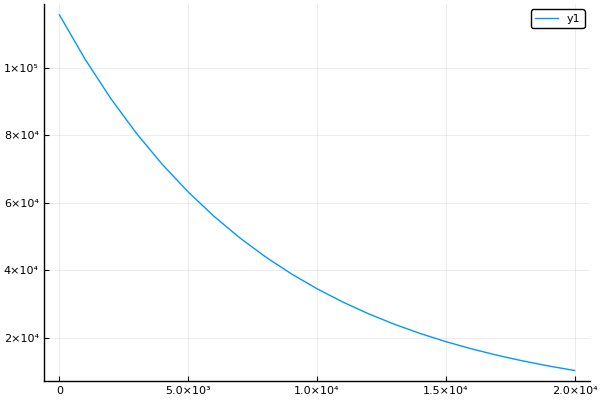

In [2]:
using Plots; pyplot()
t=0:1000:20000    # range of times, in kiloyears
plot(t, N.(t))    # syntax N.(t) applies function N to all elements of vector t
#plot(t, dN_dt.(t))

Fiddling with parameters allows plot formatting to be customised. We also add a horizontal line with the `hline!()` function. Note that `!` in function names indicates they modify the current plot rather than creating a new one.

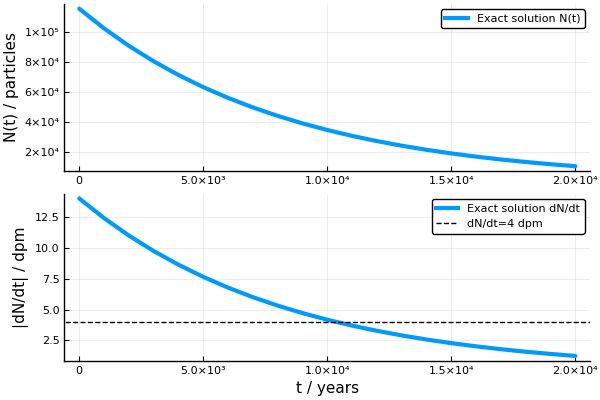

In [3]:
p1 = plot(t, N.(t), linewidth=3, label="Exact solution N(t)", ylabel="N(t) / particles")
p2 = plot(t, abs.(dN_dt.(t)), linewidth=3, label="Exact solution dN/dt",
          xlabel="t / years", ylabel="|dN/dt| / dpm")
hline!([4], color=:black, linestyle=:dash, 
       label="dN/dt=4 dpm")
plot(p1, p2, layout=(2, 1))

Since we have exact solution in this case, can rearrange equation to find precise age:

$$
\frac{\mathrm{d}N}{\mathrm{d}t} = - \lambda N_0 \exp(- \lambda t) \\\implies
T = - \frac{1}{\lambda} \log \frac{4}{14}
$$

In [4]:
T = -1 ./ λ * log(4 ./ 14)

10356.143703390073

## Numerial solution of ODEs


- Most differential equations can't be solved so easily!
- Often we can't integrate analytically and solution has to be computed numerically
- One of simplest schemes is **forward Euler** method, invented by Leonhard Euler in late 18th century
- This is a first order method with (global) error proportional to step size

## Euler's Method

<img align="right" width="30%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Euler_method.svg/220px-Euler_method.svg.png">

Starting from initial condition $A_0$, we know the local slope from differential equation.

Take a small step along tangent to $A_1$, assuming slope doesn't change much. Repeat to get to $A_2$, etc.

Errors can be made small if step size $h$ is small enough.


## Implementation of Euler's method

Writing the ODE in the form $\mathrm{d}y/\mathrm{d}t = f(t, y(t))$, the update rule is
$y_{n+1} = y_n + h\, f(t_n, y_n)$.

It's straightforward to translate this mathematical expression into Julia code

In [5]:
function euler(f, h, y0, tspan)
    t0, t1 = tspan
    t = t0:h:t1  # vector of times
    y = zero(t) # vector for solution
    y[1] = y0    # initial condition
    for n in 1:length(t)-1
        y[n+1] = y[n] + h * f(t[n], y[n])
    end    
    return t, y  # return times and values
end

euler (generic function with 1 method)

## Applying Euler's method to radioactive decay

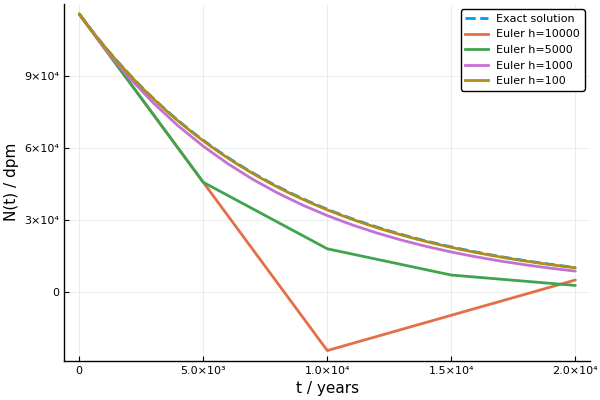

In [6]:
dN_dt(t, N) = -λ*N    # define function for differential equation model
t_exact = 0:100:20000    # for plotting exact solution
N_exact = N.(t_exact) # store for later (needed for error analysis)
p = plot(t_exact, N_exact, label="Exact solution", 
         xlabel="t / years", ylabel="N(t) / dpm", lw=2, ls=:dash)
for h in [10000, 5000, 1000, 100]
    t, N_euler = euler(dN_dt, h, N0, (0., 20000.))
    plot!(t, N_euler, label="Euler h=$h", lw=2)
end
# display(p) # show the plot
p

## Lesson Question

Demonstate that the error at a $t=20,000$ years is proportional to the step size $h$.

In [ ]:
hs = [5000, 1000, 100, 10, 1, 0.1]
error = [] # empty vector to store errors for each step size h
for h in hs
   t, N_euler = euler(dN_dt, h, N0, (0., 20000.))
   push!(error, abs(N_euler[end] - N_exact[end]))
end 
plot([hs, hs], [1.5*hs, error], xscale=:log10, yscale=:log10, 
    xlabel="log(h)", ylabel="log(error)",
    marker=[:none  :o], linewidth=[2 0], label=["1.5*h" "Error"])

## Advanced Numerical ODE Solver 

There are many ways to improve on Euler's method to give higher orders of accuracy, e.g. the families of Runge-Kutta methods (which use more function evaluations at each step) or multistep methods (which use more past steps). The details are beyond the scope of this module, but we will use the `OrdinaryDiffEq.jl` package to access some of them.

Usage is very similar to our hand-written `euler()` function:

In [ ]:
using OrdinaryDiffEq
dN_dt(N, _p, _t) = -λ*N
prob = ODEProblem(dN_dt, N0, (0., 20000.))
sol = solve(prob, RK4());

* The model is specified by writing $dN/dt = - \lambda N$ but in general ODEs can take the form 
$$
         \dot{x}(t) = f(x(t), t)
$$
and moreover, $f$ may be a function of some model parameters (e.g., $\lambda$ in the model above), i.e., $\dot{x}(t) = f(x(t), p, t)$. In this case the definition of the model would become 
```
dx_dt(x, p, t) = f(x, p, t)
```
* The parameters to `solve` are first the ODE model and second the numerical scheme to solve the ODE with, in the case above it is a so-called "Runge-Kutta Order 4" method. For other choices see [docs.juliadiffeq.org](http://docs.juliadiffeq.org/latest/solvers/ode_solve.html#OrdinaryDiffEq.jl-1).
* Solution `sol` is a composite datatype containing vectors of time and solution, and can also be evaluated to interpolate between solution points. It can even be plotted directly.

For more detail on these points and many more aspects of numerically solving ODEs in Julia, see 
* [JuliaDiffEq Tutorial](http://docs.juliadiffeq.org/latest/tutorials/ode_example.html)
* [OrdinaryDiffEq.jl](https://github.com/JuliaDiffEq/OrdinaryDiffEq.jl) 
and links in those pages.

In [ ]:
@show sol.t
@show sol.u
@show sol(10000) # interpolate between stored values

In [ ]:
# plot the numerical solution 
plot(sol, label="Numerical solution N(t)")
# plot the exact solution 
plot!(sol.t, N.(sol.t), label="Exact solution N(t)", lw=3, ls=:dash)
# add a dashed line to motivate the next problem
hline!([4/λ], color=:black, ls=:dash, lw=2, label="N(t) = 4/λ")

## Root finding with `Roots.jl`

Often we would like to find where a function is equal to zero, for example consider the cubic polynomial

$$
f(x) = (x - a)(x - b)(x - c)
$$

with $a = 2.3$, $b=3.1$ and $c = 3.6$.

In [ ]:
f(x) = (x - 2.3)*(x - 3.1)*(x - 3.6)
x = 2:0.05:4
plot(x, f.(x), lw=2, label="f(x)")
hline!([0], color=:red, lw=2, label="")

We can use the `Roots.jl` package to find roots of the equation near to a given $x$-coordinate, or to find all the roots in a given interval. Here the roots $f(x) = 0$ are at $x = a$, $x = b$ and $x = c$, but if $f(x)$ is more complicated these can be hard to find.

In [ ]:
using Roots

fzero(f, 3) # find a root of f(x) near x = 3

In [ ]:
fzeros(f, 2, 4) # find all roots of f(x) between 2 and 5

## Lesson Question

Now let's return to the earlier example of finding the age of an artifact if we know decay rate has fallen to 4 dpm, pretending we don't have access to the exact solution. We can make an initial guess from the plot of about 10,000 years, then use interpolation and `fzero()` to find where the derivative crosses the line $\mathrm{d}N/\mathrm{d}t = -4$ dpm, or equivalently where the solution crosses the line $N(t) = 4/\lambda$.

In [ ]:
age = fzero(t -> sol(t) - 4.0/λ, # define a function that is zero when our condition is met
            10000.,  # resonable initial guess
            ftol=0.1) # required precision, 0.1 years (≈ 1 month) is more than enough!

## SIR Epidemiological Model

Next we'll look at an SIR (suscpetible-infectious-recovered) model, widely used in epidemiology to model the dynamics of disesases like measles where recovery gives lasting immunity. There are three states and two proceesses:

- susceptible person and infected person combine to give two infected people at rate $\alpha$
- infected people recover at rate $\beta$

$$
S + I \to 2I \\
I \to R
$$

<center><img width="40%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/SIR.PNG/220px-SIR.PNG" ></center>

The same equations can also describe chemical reactions (the first is autocatalysing, second a simple reaction). 

This model can be expressed by the equations:

\begin{eqnarray}
\frac{dS}{dt} & = & - \alpha I S \\
\frac{dI}{dt} & = &  \alpha I S - \beta I \\
\frac{dR}{dt} & = & \beta I
\end{eqnarray}

Note that $\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$, so the total population size remains constant.

This is a non-linear model than cannot be easily solved analytically, but we can use `DifferentialEquations.jl` to obtain numerical solutions in just the same way as for the simpler case of radioactive decay.



## Julia implementation of the SIR model

In [ ]:
α = 0.8
β = 3.0
u0 = [100.0, 1.0, 0.0] # start epidemic with 49 susceptible and 1 infected
tspan = (0.0, 0.5)

function SIR!(du, u, _p, _t)  # convention: function name ends with ! as it modifies argument du in place
    S, I, R = u          # unpack u for readability
    du[1] = - α*S*I      # dS/dt
    du[2] = α*S*I - β*I  # dI/dt
    du[3] = β*I          # dR/dt
end

sir_prob = ODEProblem(SIR!, u0, tspan)
sir_sol = solve(sir_prob, RK4());

In [ ]:
plot(sir_sol, label=["Susceptible" "Infected" "Recovered"])
# check total population is constant
plot!(sir_sol.t, sum.(sir_sol.u), lw=3, label="Total", ls=:dash) 

## Using a DSL

The package [`DiffEqBiological.jl`](https://github.com/JuliaDiffEq/DiffEqBiological.jl) has implemented a DSL (domain specific language) for modelling reaction via ODEs, SDEs or jump processes. The SIR model above can be equivalently implemented as follows.

In this particular case, it does not very much simplify the implementation, but in general using a DSL can be very convenient and very powerful. 

See [Chemical Reaction Models](http://docs.juliadiffeq.org/latest/models/biological.html) for the documentation of this functionality.

In [ ]:
using DiffEqBiological
# same parameters 
α = 0.8
β = 3.0
u0 = [100.0, 1.0, 0.0] # start epidemic with 49 susceptible and 1 infected
tspan = (0.0, 0.5)

# specify the reaction network
sir_model = @reaction_network SIR begin
    c1, s + i --> 2i     # S -= 1 and I += 1 with rate c1 
    c2,     i --> r      # I -= 1 and R += 1 with rate c2
end c1 c2

# specify the resulting ODE problem and solve it 
probODE = ODEProblem(sir_model, u0, tspan, (α,β))
solnODE = solve(probODE, RK4())
plot(solnODE, lw=3, label=["Susceptible" "Infected" "Recovered"])

In [ ]:
using DiffEqBiological

## Discrete Gillespie problem

Our model is not perfect for disease propagation because we are using continuous quantities to represent discrete populations, which doesn't work well with small populations.  `OrdinaryDiffEq.jl` has support for discrete problems as well and here we see an advantage of the DSL we used: we simply have to insert the reaction network into a Discrete problem to obtain the corresponding model and solution without having to understand the underlying modelling principles. 

**Note:** This model is stochestic, hence we get a different solution every time we run the model.

For further documentation see [Discrete Stochastic (Gillespie) Equations](http://docs.juliadiffeq.org/v4.6.0/tutorials/discrete_stochastic_example.html)


In [ ]:
# keep parameters and sir_model reaction network from above 
# Setup a Stochastic Discrete Simulator 
probDISC = JumpProblem(DiscreteProblem(u0, tspan, (α,β)), Direct(), sir_model)
solDISC = solve(probDISC, FunctionMap())
;

In [ ]:
plot(solnODE, lw=1, label=["S(ode)" "I(ode)" "R(ode)"])
S, I, R = [u[1] for u in solDISC.u], [u[2] for u in solDISC.u], [u[3] for u in solDISC.u]
t = solDISC.t 
plot!(t, S, lw=3, c=1, label = "S(jump)")
plot!(t, I, lw=3, c=2, label = "I(jump)")
plot!(t, R, lw=3, c=3, label = "R(jump)")

## Extension Question

Compare the continuous and discrete implementations of the SIR models. How large does the population need to be before the continuum model is a good approximation? Hint: you will need to average over different runs as well as varying the population size.

In [ ]:
# plot(disc_sol, label=["Disc. Susceptible" "Disc. Infected" "Disc. Recovered"])
# plot!(sir_sol, ls=:dash, lw=2, color=[:blue :red :green], 
#       label=["Cont. Susceptible" "Cont. Infected" "Cont. Recovered"])